Fully Visible Sigmoid Belief Network implemented with pytorch. 

In [3]:
import numpy as np
import torch as tch
import math as m
import matplotlib.pyplot as plt

device = "cuda" if tch.cuda.is_available() else "cpu"
print("pytorch is running on " + device)

tr = np.load("train.npy")
va = np.load("valid.npy")
te = np.load("test.npy")

ttr = tch.from_numpy(np.asarray(tr, dtype=np.float32))
ds = tch.utils.data.TensorDataset(ttr)
dl = tch.utils.data.DataLoader(ds, batch_size=1000, shuffle=True)
tva = tch.from_numpy(np.asarray(va, dtype=np.float32))
tva = tva.to(device)

pytorch is running on cuda


In [4]:
# Follows the structure laid out in the pytorch tutorial
class FullyVisibleSigmoidBeliefNet(tch.nn.Module):
    def __init__(self, size):
        super().__init__()
        self.lin = tch.nn.Linear(in_features=size, out_features=size, bias=True, dtype=tch.float)
        self.apply_projection()
        self.stack = tch.nn.Sequential(self.lin, tch.nn.Sigmoid())

    # for projected SGD
    # Making the weights triangular in this way forces the network to 
    # predict future entries based only on past ones in a scan of the image.
    def apply_projection(self): 
        self.lin.weight.data.tril_(diagonal=-1)

    def forward(self, x):
        return self.stack(x)

# Train model, using validation set for early stopping
def train(model : FullyVisibleSigmoidBeliefNet, device, dl : tch.utils.data.DataLoader, validation_set = None, max_epochs = 100):
    optimizer = tch.optim.Adam(model.parameters())
    model.train() # put in training mode
    prev_loss = tch.inf
    for e in range(max_epochs):
        for batch_num, batch in enumerate(dl):
            x = batch[0].to(device) # for some reason this is a list of length 1
            optimizer.zero_grad()
            lo = log_likelihood(model, x)
            lo.backward()
            optimizer.step()
            model.apply_projection()
        if validation_set is not None:
            va_loss = log_likelihood(model, validation_set)
            if m.isclose(prev_loss, va_loss, rel_tol=0.0001):
                print("Exiting early at epoch " + str(e))
                break
            prev_loss = va_loss
    return model

# Generate a sample from the model
def sample(model : FullyVisibleSigmoidBeliefNet):
    model.eval() # put in eval mode
    size = len(model.lin.weight)
    output = tch.zeros(size, dtype=tch.float, device=model.lin.weight.device)
    rands = tch.rand(size, device=model.lin.weight.device)
    for i in range(size):
        if rands[i] < model(output)[i]:
            output[i] = 1.
    return output

def log_likelihood(model : FullyVisibleSigmoidBeliefNet, data):
    y = model(data)
    return -tch.mean(tch.sum(tch.log(tch.where(data != 0, y, 1 - y)), dim=1))


In [5]:
belief_model = FullyVisibleSigmoidBeliefNet(28 * 28).to(device)
belief_model = train(belief_model, device, dl, tva)

<BarContainer object of 784 artists>

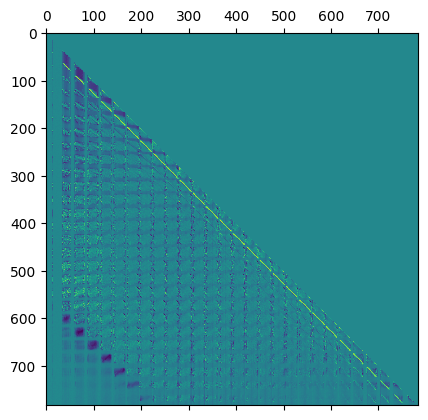

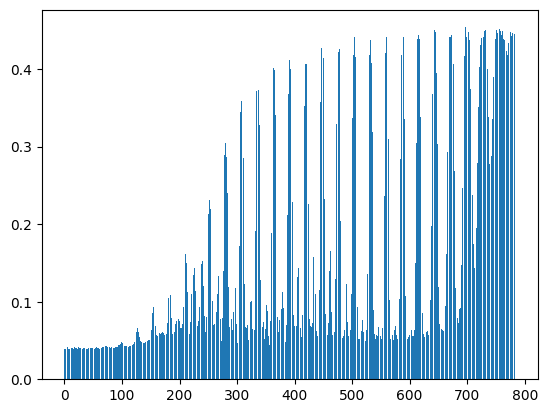

In [6]:
sig = tch.nn.Sigmoid()
w = sig(belief_model.lin.weight).cpu().detach().numpy()
plt.matshow(w)
plt.figure()
bi = sig(belief_model.lin.bias).cpu().detach().numpy()
plt.bar(np.arange(28 * 28), bi)

Test set log likelihood.

In [7]:
tte = tch.from_numpy(np.asarray(te, dtype=np.float32)).to(device)
log_likelihood(belief_model, tte)

tensor(104.7202, device='cuda:0', grad_fn=<NegBackward0>)

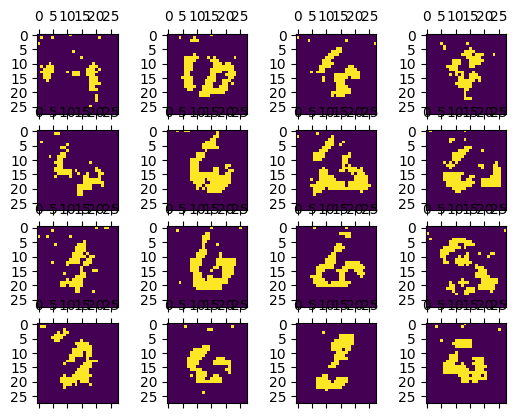

In [8]:
fig, axs = plt.subplots(4, 4)
for i in range(16):
    axs[i // 4, i % 4].matshow(np.reshape(sample(belief_model).cpu(), (28, 28)))